In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [ ]:
df = pd.read_excel('java_tourism.xlsx')
df.head()

,id,place_name,deskripsi,reviews_link,rating,total_reviews,address,city,province,gambar
0,1,4G Peak Gedangsari,4G Peak Gedangsari adalah puncak wisata alam y...,https://serpapi.com/search.json?data_id=0x2e7a...,4.4,353,"4HRC+3CV, Manggung, Ngalang, Gedang Sari, Gunu...",gunung kidul,yogyakarta,4G Peak Gedangsari.png
1,2,Ade Irma Suryani Nasution Traffic Garden,Ade Irma Suryani Nasution Traffic Garden adala...,https://serpapi.com/search.json?data_id=0x2e68...,4.4,13178,"Jl. Belitung No.1, Merdeka, Sumurbandung, Band...",bandung,jawa barat,Ade Irma Suryani Nasution Traffic Garden.jpg
2,3,Agro Tourism Bhumi Merapi,Agro Tourism Bhumi Merapi adalah destinasi wis...,https://serpapi.com/search.json?data_id=0x2e7a...,4.5,13960,"Jl. Kaliurang No.Km.20, Sawungan, Hargobinangu...",sleman,yogyakarta,Agro Tourism Bhumi Merapi.jpg
3,4,Air Mancur Menari Manahan,Air Mancur Menari Manahan adalah atraksi wisat...,https://serpapi.com/search.json?data_id=0x2e7a...,4.5,80,"Manahan, Kec. Banjarsari, Kota Surakarta, Jawa...",surakarta,jawa tengah,Air Mancur Menari Manahan.jpeg
4,5,Air Terjun Banyu Anjlok,Air Terjun Banyu Anjlok adalah air terjun yang...,https://serpapi.com/search.json?data_id=0x2e70...,4.5,240,"Somosari VI, Somosari, Kec. Batealit, Kabupate...",jepara,jawa tengah,Air Terjun Banyu Anjlok.png


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 868 entries, 0 to 867
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             868 non-null    int64  
 1   place_name     868 non-null    object 
 2   deskripsi      868 non-null    object 
 3   reviews_link   868 non-null    object 
 4   rating         868 non-null    float64
 5   total_reviews  868 non-null    int64  
 6   address        868 non-null    object 
 7   city           868 non-null    object 
 8   province       868 non-null    object 
 9   gambar         868 non-null    object 
dtypes: float64(1), int64(2), object(7)
memory usage: 67.9+ KB


In [ ]:
keywords = {
    'alam': ['gunung', 'pantai', 'danau', 'air terjun', 'hutan', 'taman nasional', 'cagar alam', 'gua', 'pemandangan', 'alam', 'sungai', 'laut'],
    'buatan': ['taman hiburan', 'museum', 'monumen', 'tempat wisata', 'kebun binatang', 'waterpark', 'kolam renang', 'gedung', 'bangunan', 'buatan', 'buatan manusia', 'theme park'],
    'budaya': ['budaya', 'tradisional', 'adat', 'seni', 'pertunjukan', 'sejarah', 'kerajaan', 'festival', 'tari', 'musik', 'candi', 'batik', 'keraton'],
    'religi': ['masjid', 'gereja', 'pura', 'vihara', 'kuil', 'makam', 'ziarah', 'religi', 'agama', 'keramat', 'rohani'],
    'edukasi': ['edukasi', 'pendidikan', 'belajar', 'ilmu pengetahuan', 'sekolah', 'universitas', 'planetarium', 'observatorium', 'arkeologi', 'penelitian', 'sains', 'iptek']
}

In [ ]:
def tag_labels(description):
    description = description.lower()
    labels = {key: 0 for key in keywords.keys()}
    for label, kws in keywords.items():
        for kw in kws:
            if kw in description:
                labels[label] = 1
                break
    return labels

label_df = df['deskripsi'].apply(tag_labels).apply(pd.Series)
df = pd.concat([df, label_df], axis=1)

print("Data dengan label tipe wisata:")

Data dengan label tipe wisata:


In [ ]:
df.head()

,id,place_name,deskripsi,reviews_link,rating,total_reviews,address,city,province,gambar,alam,buatan,budaya,religi,edukasi
0,1,4G Peak Gedangsari,4G Peak Gedangsari adalah puncak wisata alam y...,https://serpapi.com/search.json?data_id=0x2e7a...,4.4,353,"4HRC+3CV, Manggung, Ngalang, Gedang Sari, Gunu...",gunung kidul,yogyakarta,4G Peak Gedangsari.png,1,0,0,0,0
1,2,Ade Irma Suryani Nasution Traffic Garden,Ade Irma Suryani Nasution Traffic Garden adala...,https://serpapi.com/search.json?data_id=0x2e68...,4.4,13178,"Jl. Belitung No.1, Merdeka, Sumurbandung, Band...",bandung,jawa barat,Ade Irma Suryani Nasution Traffic Garden.jpg,0,0,0,0,1
2,3,Agro Tourism Bhumi Merapi,Agro Tourism Bhumi Merapi adalah destinasi wis...,https://serpapi.com/search.json?data_id=0x2e7a...,4.5,13960,"Jl. Kaliurang No.Km.20, Sawungan, Hargobinangu...",sleman,yogyakarta,Agro Tourism Bhumi Merapi.jpg,0,0,0,0,1
3,4,Air Mancur Menari Manahan,Air Mancur Menari Manahan adalah atraksi wisat...,https://serpapi.com/search.json?data_id=0x2e7a...,4.5,80,"Manahan, Kec. Banjarsari, Kota Surakarta, Jawa...",surakarta,jawa tengah,Air Mancur Menari Manahan.jpeg,1,1,1,0,0
4,5,Air Terjun Banyu Anjlok,Air Terjun Banyu Anjlok adalah air terjun yang...,https://serpapi.com/search.json?data_id=0x2e70...,4.5,240,"Somosari VI, Somosari, Kec. Batealit, Kabupate...",jepara,jawa tengah,Air Terjun Banyu Anjlok.png,1,0,0,0,0


In [ ]:
# Memeriksa data yang hilang
print("Data yang hilang di setiap kolom:")
print(df.isnull().sum())

# Memeriksa duplikasi
print("\nData duplikat:")
print(df.duplicated().sum())


Data yang hilang di setiap kolom:
id               0
place_name       0
deskripsi        0
reviews_link     0
rating           0
total_reviews    0
address          0
city             0
province         0
gambar           0
alam             0
buatan           0
budaya           0
religi           0
edukasi          0
dtype: int64

Data duplikat:
0


In [ ]:
# Statistik deskriptif untuk data numerik
print("\nStatistik Deskriptif:")
print(df.describe())



Statistik Deskriptif:
               id      rating  total_reviews        alam      buatan  \
count  868.000000  868.000000     868.000000  868.000000  868.000000   
mean   434.500000    4.423502    3590.025346    0.808756    0.307604   
std    250.714313    0.236274    8968.370154    0.393508    0.461768   
min      1.000000    2.500000       1.000000    0.000000    0.000000   
25%    217.750000    4.300000     194.500000    1.000000    0.000000   
50%    434.500000    4.400000     727.000000    1.000000    0.000000   
75%    651.250000    4.600000    2907.750000    1.000000    1.000000   
max    868.000000    5.000000   97549.000000    1.000000    1.000000   

           budaya      religi     edukasi  
count  868.000000  868.000000  868.000000  
mean     0.252304    0.065668    0.176267  
std      0.434585    0.247844    0.381267  
min      0.000000    0.000000    0.000000  
25%      0.000000    0.000000    0.000000  
50%      0.000000    0.000000    0.000000  
75%      1.000000   

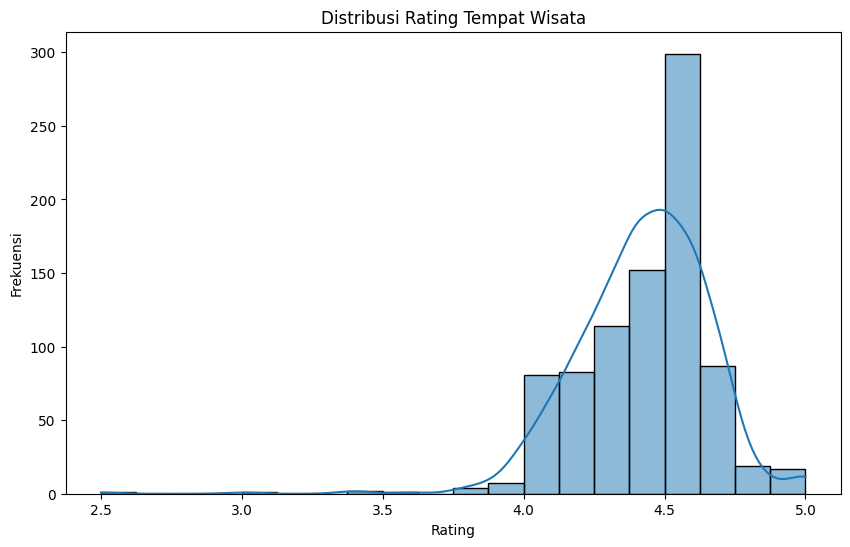

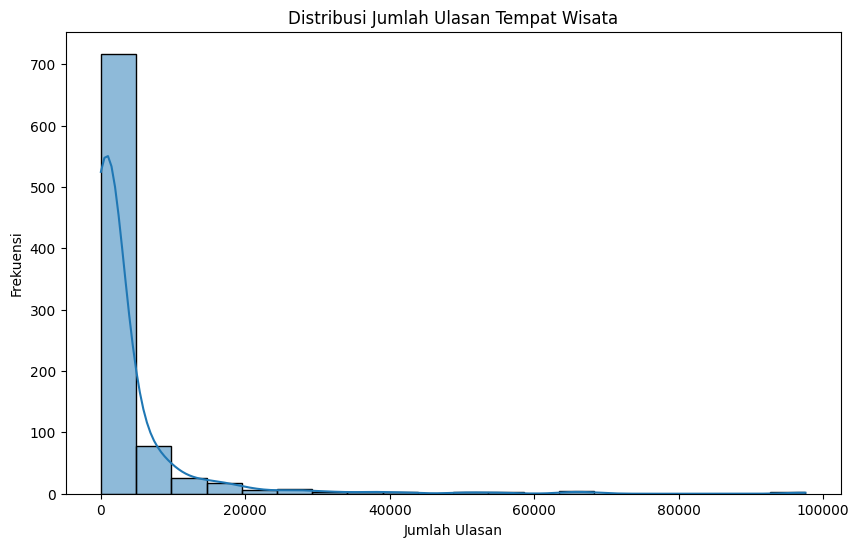

In [ ]:
# Visualisasi distribusi rating
plt.figure(figsize=(10, 6))
sns.histplot(df['rating'], bins=20, kde=True)
plt.title('Distribusi Rating Tempat Wisata')
plt.xlabel('Rating')
plt.ylabel('Frekuensi')
plt.show()

# Visualisasi distribusi jumlah ulasan
plt.figure(figsize=(10, 6))
sns.histplot(df['total_reviews'], bins=20, kde=True)
plt.title('Distribusi Jumlah Ulasan Tempat Wisata')
plt.xlabel('Jumlah Ulasan')
plt.ylabel('Frekuensi')
plt.show()


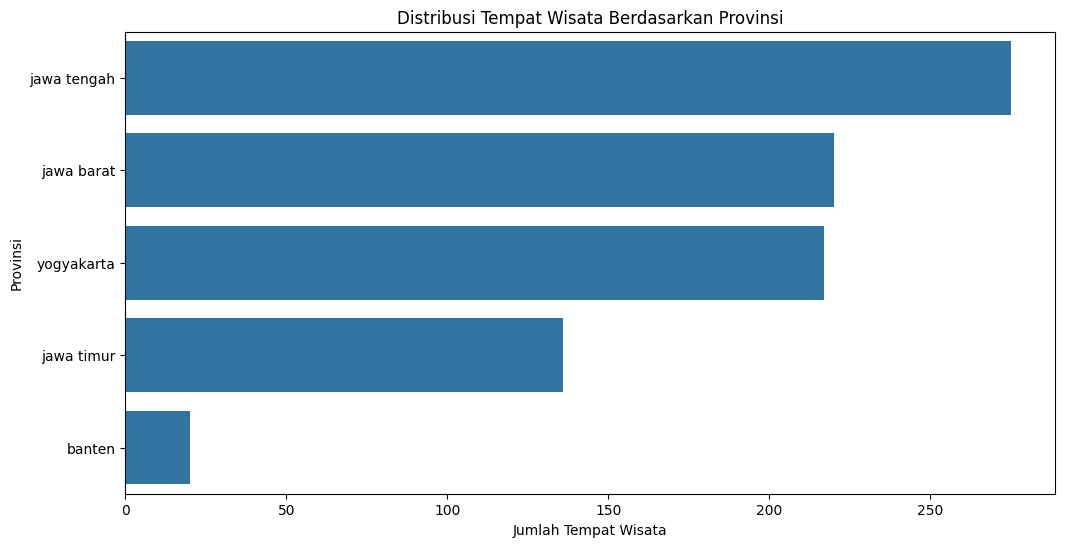

In [ ]:
# Visualisasi jumlah tempat wisata berdasarkan provinsi
plt.figure(figsize=(12, 6))
sns.countplot(y='province', data=df, order=df['province'].value_counts().index)
plt.title('Distribusi Tempat Wisata Berdasarkan Provinsi')
plt.xlabel('Jumlah Tempat Wisata')
plt.ylabel('Provinsi')
plt.show()

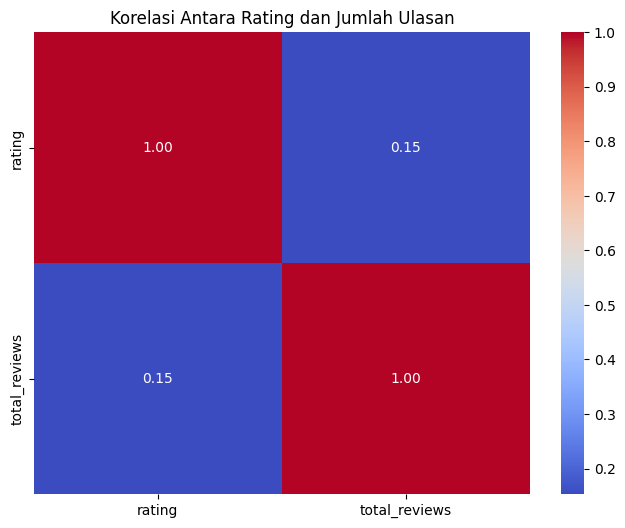

In [ ]:
# Korelasi antara rating dan jumlah ulasan
corr_matrix = df[['rating', 'total_reviews']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Korelasi Antara Rating dan Jumlah Ulasan')
plt.show()


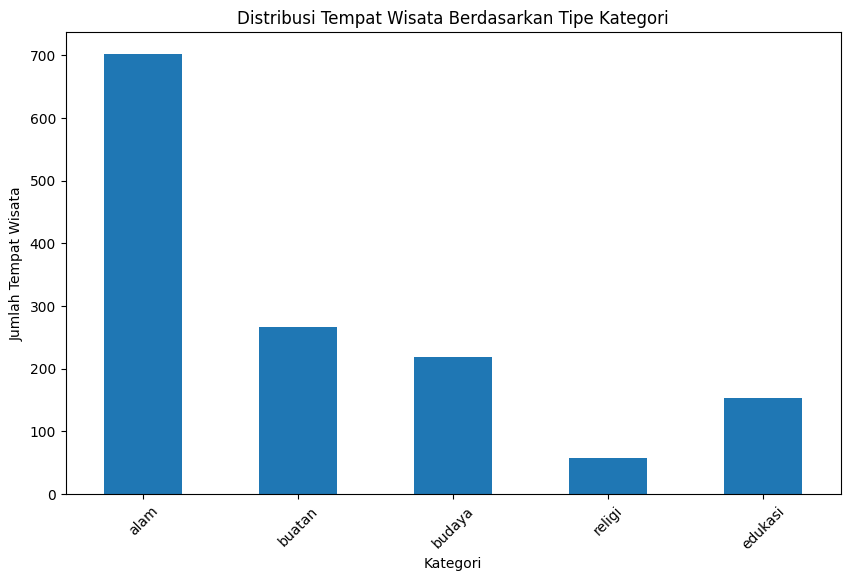

In [ ]:
# Visualisasi jumlah tempat wisata berdasarkan tipe kategori (alam, buatan, dll)
category_columns = ['alam', 'buatan', 'budaya', 'religi', 'edukasi']
category_counts = df[category_columns].sum()

plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar')
plt.title('Distribusi Tempat Wisata Berdasarkan Tipe Kategori')
plt.ylabel('Jumlah Tempat Wisata')
plt.xlabel('Kategori')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# ----------------------------
# TOKENIZER & SEQUENCE PREPARATION
# ----------------------------

texts = df['deskripsi'].tolist()
labels = df[['alam', 'buatan', 'budaya', 'religi', 'edukasi']].values

max_words = 1000
max_len = 50

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
x_data = pad_sequences(sequences, maxlen=max_len)


In [ ]:
# Split train-val (simple split)
train_size = int(len(x_data) * 0.8)
x_train, x_val = x_data[:train_size], x_data[train_size:]
y_train, y_val = labels[:train_size], labels[train_size:]

In [ ]:
# ----------------------------
# MODEL BUILDING
# ----------------------------

from tensorflow.keras.layers import LSTM, Dropout

# ----------------------------
# MODEL BUILDING (LSTM)
# ----------------------------

input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim=max_words, output_dim=64, input_length=max_len)(input_layer)

# LSTM layer
lstm_layer = LSTM(128, return_sequences=False)(embedding_layer)

# Optional Dropout layer to avoid overfitting
dropout_layer = Dropout(0.5)(lstm_layer)

# Dense layer for further representation
dense_layer = Dense(64, activation='relu')(dropout_layer)

# Output layer
output_layer = Dense(5, activation='sigmoid')(dense_layer)

# Create model
model_lstm = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary of the LSTM model
print(model_lstm.summary())


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 50, 64)         │        64,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,397 (669.52 KB)

 Trainable params: 171,397 (669.52 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# ----------------------------
# TRAINING (MODIFIKASI)
# ----------------------------

from tensorflow.keras.callbacks import EarlyStopping

# Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Training model with EarlyStopping
history_lstm = model_lstm.fit(
    x_train, y_train,
    epochs=10,  # Bisa ditingkatkan lebih tinggi
    batch_size=16,
    validation_data=(x_val, y_val),
    callbacks=[early_stop]
)


Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.7682 - loss: 0.5942 - val_accuracy: 0.8333 - val_loss: 0.4281
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.7965 - loss: 0.4083 - val_accuracy: 0.7529 - val_loss: 0.3607
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.7451 - loss: 0.3340 - val_accuracy: 0.7701 - val_loss: 0.3264
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.7479 - loss: 0.3135 - val_accuracy: 0.7989 - val_loss: 0.2881
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.7453 - loss: 0.2686 - val_accuracy: 0.8391 - val_loss: 0.2859
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8159 - loss: 0.2321 - val_accuracy: 0.8218 - val_loss: 0.2230
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8031 - loss: 0.1969 - val_accuracy: 0.8276 - val_loss: 0.2227
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8071 - loss: 0.1869 - val_accuracy: 0.8391 - v

In [ ]:
from sklearn.metrics import classification_report

# Definisikan label_names
label_names = ['alam', 'buatan', 'budaya', 'religi', 'edukasi']

# ----------------------------
# EVALUASI MODEL
# ----------------------------

# Evaluasi model pada set validasi
loss, accuracy = model_lstm.evaluate(x_val, y_val, verbose=0)
print(f"\nEvaluasi Model LSTM pada Set Validasi:")
print(f"Loss: {loss:.4f}")
print(f"Akurasi: {accuracy:.4f}")

# Prediksi probabilitas pada set validasi
y_pred_probs_lstm = model_lstm.predict(x_val)

# Mengonversi probabilitas menjadi prediksi biner menggunakan ambang batas (misalnya, 0.5)
y_pred_bin_lstm = (y_pred_probs_lstm >= 0.5).astype(int)

# Laporan klasifikasi untuk model LSTM
print("\nLaporan Klasifikasi pada Set Validasi untuk Model LSTM:")
print(classification_report(y_val, y_pred_bin_lstm, target_names=label_names, zero_division=0))



Evaluasi Model LSTM pada Set Validasi:
Loss: 0.1947
Akurasi: 0.8563
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

Laporan Klasifikasi pada Set Validasi untuk Model LSTM:
              precision    recall  f1-score   support

        alam       0.94      0.99      0.96       145
      buatan       0.95      0.76      0.85        55
      budaya       0.76      0.78      0.77        36
      religi       0.54      0.64      0.58        11
     edukasi       0.77      0.74      0.76        23

   micro avg       0.88      0.88      0.88       270
   macro avg       0.79      0.78      0.78       270
weighted avg       0.89      0.88      0.88       270
 samples avg       0.93      0.92      0.91       270



In [ ]:
# ----------------------------
# PREDIKSI LABEL DARI INPUT USER
# ----------------------------

def predict_labels(text):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len)
    preds = model_lstm.predict(padded)[0]
    labels_pred = {label: float(preds[i]) for i, label in enumerate(['alam', 'buatan', 'budaya', 'religi', 'edukasi'])}
    # Threshold 0.5 untuk keputusan 0/1
    labels_bin = {k: int(v >= 0.5) for k, v in labels_pred.items()}
    return labels_bin, labels_pred


In [ ]:
# ----------------------------
# REKOMENDASI BERBASIS SIMILARITY DENGAN THRESHOLD
# ----------------------------

def recommend_places(user_province, user_labels, user_description, df, top_n=10, threshold=0.10):
    # Filter provinsi
    filtered_df = df[df['province'].str.lower() == user_province.lower()]
    if filtered_df.empty:
        return "Maaf, tidak ada tempat di provinsi tersebut."

    # Filter tipe wisata sesuai input user (minimal satu tipe match)
    selected_labels = [label for label, val in user_labels.items() if val == 1]
    if not selected_labels:
        return "Mohon pilih minimal satu tipe wisata."

    mask = filtered_df[selected_labels].sum(axis=1) > 0
    filtered_df = filtered_df[mask]
    if filtered_df.empty:
        return "Maaf, tidak ada tempat dengan tipe wisata tersebut di provinsi itu."

    # Vektorisasi dengan TF-IDF
    corpus = filtered_df['deskripsi'].tolist()
    corpus_with_query = corpus + [user_description]
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(corpus_with_query)

    cosine_sim = cosine_similarity(tfidf_matrix[-1], tfidf_matrix[:-1]).flatten()

    # Filter berdasarkan threshold
    top_indices = cosine_sim.argsort()[::-1]
    top_indices = [idx for idx in top_indices if cosine_sim[idx] >= threshold][:top_n]  # Terapkan threshold

    # Jika tidak ada tempat yang memenuhi threshold
    if len(top_indices) == 0:
        return "Maaf, tidak ada tempat dengan kemiripan yang cukup di provinsi tersebut."

    recommendations = filtered_df.iloc[top_indices]

    result = []
    for idx, score in zip(top_indices, cosine_sim[top_indices]):
        place = filtered_df.iloc[idx]
        result.append({
            'place_name': place['place_name'],
            'province': place['province'],
            'deskripsi': place['deskripsi'],
            'gambar': place['gambar'],
            'similarity_score': float(score)
        })

    return result


In [ ]:
# ----------------------------
# INTERAKSI USER (INPUT LANGSUNG)
# ----------------------------

print("\n==== SISTEM REKOMENDASI WISATA ====\n")

# Input langsung dari user
user_province = input("Masukkan provinsi tujuan wisata: ").strip()

tipe_input = input("Masukkan tipe wisata yang diinginkan (pisahkan dengan koma, contoh: alam, budaya, religi): ").strip().lower()
selected_labels_input = [tipe.strip() for tipe in tipe_input.split(",")]

user_input_desc = input("Masukkan ciri-ciri tempat wisata (kalimat bebas): ").strip()

# Validasi dan buat dictionary tipe wisata
all_labels = ['alam', 'buatan', 'budaya', 'religi', 'edukasi']
selected_labels = {label: 1 if label in selected_labels_input else 0 for label in all_labels}

# Cetak ringkasan input user
print("\n=== RINGKASAN INPUT USER ===")
print("Provinsi:", user_province)
print("Tipe wisata dipilih:", [k for k, v in selected_labels.items() if v == 1])
print("Ciri-ciri input:", user_input_desc)

# Prediksi tipe wisata dari deskripsi
user_labels_bin, user_labels_prob = predict_labels(user_input_desc)
print("\n=== Prediksi Sistem Berdasarkan Ciri-ciri ===")
print("Probabilitas Label:", {k: f"{v:.2f}" for k,v in user_labels_prob.items()})

# Jalankan rekomendasi
recommendations = recommend_places(user_province, selected_labels, user_input_desc, df, top_n=10)

# Tampilkan hasil
if isinstance(recommendations, str):
    print("\n" + recommendations)
else:
    print("\n=== Rekomendasi Tempat Wisata ===\n")
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. Nama Tempat : {rec['place_name']}")
        print(f"   Provinsi    : {rec['province']}")
        print(f"   Deskripsi   : {rec['deskripsi']}")
        print(f"   Gambar      : {rec['gambar']}")
        print(f"   Skor Kemiripan: {rec['similarity_score']:.4f}")
        print("-" * 50)



==== SISTEM REKOMENDASI WISATA ====

Masukkan provinsi tujuan wisata: jawa barat
Masukkan tipe wisata yang diinginkan (pisahkan dengan koma, contoh: alam, budaya, religi): alam
Masukkan ciri-ciri tempat wisata (kalimat bebas): gunung yang indah

=== RINGKASAN INPUT USER ===
Provinsi: jawa barat
Tipe wisata dipilih: ['alam']
Ciri-ciri input: gunung yang indah
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

=== Prediksi Sistem Berdasarkan Ciri-ciri ===
Probabilitas Label: {'alam': '0.56', 'buatan': '0.24', 'budaya': '0.72', 'religi': '0.65', 'edukasi': '0.21'}

=== Rekomendasi Tempat Wisata ===

1. Nama Tempat : Gunung Padang
   Provinsi    : jawa barat
   Deskripsi   : Gunung Padang adalah situs megalitikum prasejarah yang menawarkan wisata budaya dan sejarah yang mendalam. Pengunjung dapat menjelajahi peninggalan purbakala dan belajar tentang peradaban kuno yang pernah mendiami area ini.
   Gambar      : Gunung Padang.jpg
   Skor Kemiripan: 0.2022
----------------------------------------------

In [ ]:
model_lstm.save('multilabel_model.h5')

import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)


In [ ]:
df.to_excel('java.xlsx', index=False)


In [ ]:
from google.colab import files
files.download('java.xlsx')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Insight dari Data

## 1. Distribusi Rating
- **Mayoritas tempat wisata** memiliki rating yang cukup tinggi (antara 4 hingga 5), menunjukkan bahwa sebagian besar tempat wisata dinilai dengan baik oleh pengunjung.

## 2. Distribusi Jumlah Ulasan
- **Sebagian besar tempat wisata** memiliki sedikit ulasan (di bawah 1.000 ulasan), sementara ada beberapa tempat wisata dengan ulasan yang sangat tinggi. Ini menunjukkan adanya **ketidakseimbangan** dalam jumlah ulasan yang diterima oleh tempat wisata.

## 3. Distribusi Berdasarkan Provinsi
- **Jawa Tengah** dan **Jawa Barat** memiliki jumlah tempat wisata terbanyak, sedangkan **Banten** memiliki jumlah tempat wisata yang jauh lebih sedikit. Ini menunjukkan adanya konsentrasi tempat wisata yang lebih tinggi di beberapa provinsi tertentu.

## 4. Distribusi Berdasarkan Kategori Wisata
- **Kategori `alam`** mendominasi jumlah tempat wisata, sementara kategori lainnya seperti **`religi`** dan **`edukasi`** jauh lebih sedikit. Ini mungkin menunjukkan minat yang lebih tinggi pada wisata alam di Indonesia.

## 5. Korelasi Rating dan Jumlah Ulasan
- **Korelasi rendah** antara rating dan jumlah ulasan (0.15), yang berarti bahwa tempat wisata dengan jumlah ulasan tinggi tidak selalu memiliki rating yang lebih baik, menunjukkan **variabilitas** dalam kualitas ulasan.

## 6. Ketidakseimbangan Data
- Kategori **`religi`** memiliki **data yang sangat sedikit**, yang dapat menyebabkan **model kesulitan** dalam mengklasifikasikan tempat wisata dalam kategori ini, sehingga mempengaruhi kinerja model pada kategori tersebut.

## 7. Kata Kunci dalam Deskripsi
- **Kata kunci** seperti `gunung`, `pantai`, `air terjun` sering muncul dalam deskripsi tempat wisata, yang menunjukkan bahwa tempat wisata alam (seperti gunung dan pantai) mendominasi dataset.

---

## Kesimpulan:
- **Rating tinggi dan ulasan terbatas**: Banyak tempat wisata yang mendapat rating tinggi tetapi dengan sedikit ulasan. Hal ini menunjukkan bahwa beberapa tempat mungkin kurang dikenal meskipun mendapat penilaian positif.
- **Dominasi kategori alam**: Dataset didominasi oleh kategori wisata alam, sementara kategori lainnya seperti **religi** memiliki lebih sedikit data.
- **Ketidakseimbangan data**: Ada ketidakseimbangan pada kategori tertentu, yang dapat mempengaruhi akurasi model dalam klasifikasi multi-label, terutama untuk kategori **`religi`**.
